In [38]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Load all datasets
train_proteins = pd.read_csv("./input/train_proteins.csv")
train_clinical = pd.read_csv("./input/train_clinical_data.csv")
train_peptides = pd.read_csv("./input/train_peptides.csv")
supplemental_clinical = pd.read_csv("./input/supplemental_clinical_data.csv")

In [3]:
train_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [4]:
train_peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [5]:
train_clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [6]:
# Pivot the proteins and peptides tables so each protein and peptide is a feature
train_proteins = train_proteins.pivot_table(values="NPX", index="visit_id", columns="UniProt")
train_peptides = train_peptides.pivot_table(values="PeptideAbundance", index="visit_id", columns="Peptide")

In [7]:
# Merge the three tables
train = train_clinical.merge(train_proteins, on="visit_id", how="left")  \
                      .merge(train_peptides, on="visit_id", how="left")

In [8]:
train.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,201158.0,16492.3,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,171079.0,13198.8,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
3,55_9,55,9,8.0,9.0,30.0,0.0,On,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,231772.0,17873.8,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1


In [9]:
# Set the patient id as index
train = train.set_index(["patient_id"])

In [10]:
# An overview of the new tables
train.head(20)

,visit_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,O00584,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,55_0,0,10.0,6.0,15.0,NaN,NaN,11254.30,732430.0,39585.8,...,201158.0,16492.30,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
55,55_3,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_6,6,8.0,10.0,34.0,NaN,NaN,13163.60,630465.0,35220.8,...,171079.0,13198.80,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
55,55_9,9,8.0,9.0,30.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_12,12,10.0,10.0,41.0,0.0,On,15257.60,815083.0,41650.9,...,231772.0,17873.80,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1
55,55_18,18,7.0,13.0,38.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_24,24,16.0,9.0,49.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_30,30,14.0,13.0,49.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_36,36,17.0,18.0,51.0,0.0,On,13530.80,753832.0,43048.9,...,185290.0,18580.50,2659660.0,90936.9,679163.0,128593.0,203680.0,498621.0,52792.7,13973.7


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2615 entries, 55 to 65043
Columns: 1202 entries, visit_id to YYWGGQYTWDMAK
dtypes: float64(1199), int64(1), object(2)
memory usage: 24.0+ MB


In [12]:
train = train.drop("visit_id", axis=1)

In [13]:
# Create a list of the ids of the patients
patient_id = list(train.index.unique())

In [14]:
# Check missing values
print(train.isna().sum().sum())

1962306


In [15]:
# Interpolate the missing data of every patient
for patient in patient_id:
    train.loc[patient] = train.loc[patient].interpolate(method="linear").fillna(method="bfill")

In [16]:
# Fill updrs and state of medication values
train.updrs_4 = train.updrs_4.fillna(0)
train.upd23b_clinical_state_on_medication = train.upd23b_clinical_state_on_medication.fillna("Off")

In [17]:
# Adjust updr4 values to possible values
train.updrs_4 = round(train.updrs_4)

In [18]:
# Check missing values after interpolate
print("Total missing values left: {}".format(train.isna().sum().sum()))
print(train.isna().sum().sort_values(ascending=False))

Total missing values left: 80927
EPQVYTLPPSRDELTK                                       1230
ALVQQMEQLR                                              778
AVGDKLPEC(UniMod_4)EADDGC(UniMod_4)PKPPEIAHGYVEHSVR     741
HYEGSTVPEK                                              683
QQLVETHMAR                                              662
                                                       ... 
DDNPNLPR                                                  0
DFADIPNLR                                                 0
DIPMNPMC(UniMod_4)IYR                                     0
DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR                  0
visit_month                                               0
Length: 1201, dtype: int64


In [19]:

# Fill the remaining na values with the mean of the columns
train = train.fillna(train.mean())

c:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [20]:
train.head(20)

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,0,10.0,6.0,15.0,0.0,On,11254.300000,732430.00,39585.80,41526.900,...,201158.00,16492.300,3810270.0,106894.000,580667.0,131155.000,165851.000,437305.0,46289.200,14898.400000
55,3,10.0,7.0,25.0,0.0,On,12208.950000,681447.50,37403.30,41410.950,...,186118.50,14845.550,3964895.0,110139.500,547764.0,117333.500,155229.000,447598.0,43168.450,17801.150000
55,6,8.0,10.0,34.0,0.0,On,13163.600000,630465.00,35220.80,41295.000,...,171079.00,13198.800,4119520.0,113385.000,514861.0,103512.000,144607.000,457891.0,40047.700,20703.900000
55,9,8.0,9.0,30.0,0.0,On,14210.600000,722774.00,38435.85,40529.150,...,201425.50,15536.300,4796830.0,114835.500,613338.0,120227.500,163185.000,455072.0,47386.400,21272.500000
55,12,10.0,10.0,41.0,0.0,On,15257.600000,815083.00,41650.90,39763.300,...,231772.00,17873.800,5474140.0,116286.000,711815.0,136943.000,181763.000,452253.0,54725.100,21841.100000
55,18,7.0,13.0,38.0,0.0,On,14825.900000,799770.25,42000.40,40698.375,...,220151.50,18050.475,4770520.0,109948.725,703652.0,134855.500,187242.250,463845.0,54242.000,19874.250000
55,24,16.0,9.0,49.0,0.0,On,14394.200000,784457.50,42349.90,41633.450,...,208531.00,18227.150,4066900.0,103611.450,695489.0,132768.000,192721.500,475437.0,53758.900,17907.400000
55,30,14.0,13.0,49.0,0.0,On,13962.500000,769144.75,42699.40,42568.525,...,196910.50,18403.825,3363280.0,97274.175,687326.0,130680.500,198200.750,487029.0,53275.800,15940.550000
55,36,17.0,18.0,51.0,0.0,On,13530.800000,753832.00,43048.90,43503.600,...,185290.00,18580.500,2659660.0,90936.900,679163.0,128593.000,203680.000,498621.0,52792.700,13973.700000


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2615 entries, 55 to 65043
Columns: 1201 entries, visit_month to YYWGGQYTWDMAK
dtypes: float64(1199), int64(1), object(1)
memory usage: 24.0+ MB


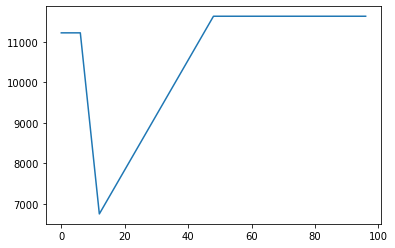

In [22]:
# Plot peptide levels over time
plt.plot(train.loc[942, "visit_month"], train.loc[942, "O00391"])
plt.show()

In [23]:
s = train.columns.values
e = ['upd23b_clinical_state_on_medication', 'visit_month']
norm_columns = set(train.columns.values)-set(e)
print(len(set(train.columns.values)))
print(len(set(train.columns.values)-set(e)))

1201
1199


In [24]:
# Now we shall normalize all the columns values with the exception of two columns
updrs_cols = ['updrs_1','updrs_2','updrs_3','updrs_4']
for col in norm_columns:
    train[col] = (train[col] - train[col].min()) / (train[col].max() - train[col].min())    

train.head()

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,0,0.303030,0.150,0.174419,0.0,On,0.506663,0.385009,0.589438,0.577661,...,0.475128,0.592219,0.266399,0.148896,0.144114,0.519776,0.626289,0.454550,0.395872,0.202879
55,3,0.303030,0.175,0.290698,0.0,On,0.553258,0.355831,0.555836,0.575605,...,0.437318,0.532145,0.277691,0.153454,0.135841,0.464635,0.585936,0.465535,0.364930,0.244856
55,6,0.242424,0.250,0.395349,0.0,On,0.599854,0.326652,0.522234,0.573549,...,0.399509,0.472072,0.288983,0.158013,0.127568,0.409494,0.545584,0.476519,0.333988,0.286832
55,9,0.242424,0.225,0.348837,0.0,On,0.650957,0.379483,0.571733,0.559971,...,0.475800,0.557344,0.338447,0.160050,0.152329,0.476181,0.616161,0.473511,0.406751,0.295055
55,12,0.303030,0.250,0.476744,0.0,On,0.702060,0.432313,0.621233,0.546393,...,0.552091,0.642616,0.387911,0.162088,0.177089,0.542868,0.686737,0.470502,0.479514,0.303277


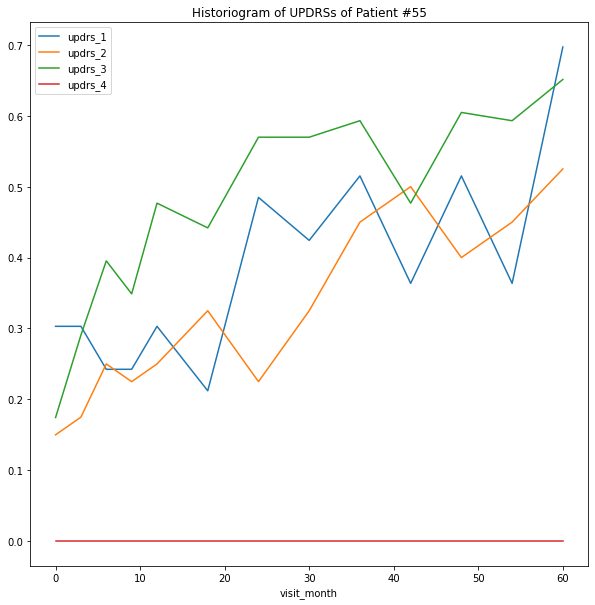

In [25]:
# We shall plot the evoltion of each updrs in time
patient = patient_id[0]
train.loc[patient].plot(x="visit_month", y=updrs_cols,
        kind="line", figsize=(10, 10))
plt.title(f'Historiogram of UPDRSs of Patient #{patient}')
plt.show() 

In [26]:
#  We shall define a linear regression method for each updrs
def linear_regressor_method(X,Y):
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    return linear_regressor

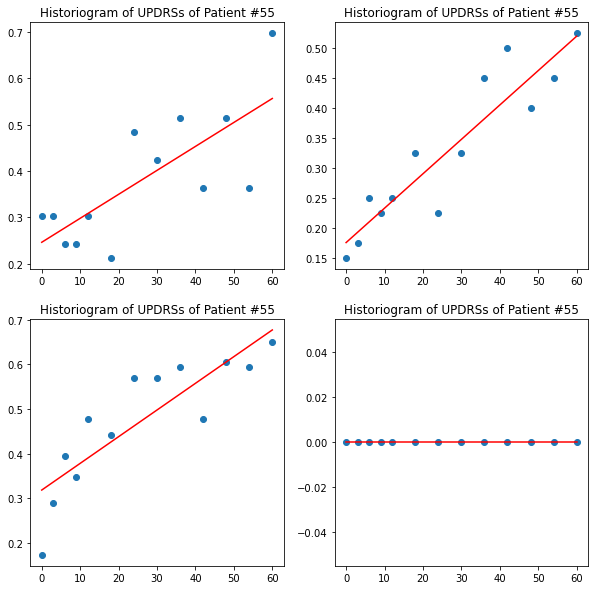

In [27]:
# Estimating updrs of one patient based on month_visit
# We shall invoke previous method 
linear_regressors_list = []
fig, axs = plt.subplots(2, 2,figsize=(10,10))
aux = 0
for idx, updrs in enumerate(updrs_cols):
    np_x = train.loc[patient]['visit_month'].values.reshape(-1, 1)
    np_y = train.loc[patient][updrs].values.reshape(-1, 1) 
    lr = linear_regressor_method(np_x, np_y)
    if(aux == 2):
        aux = 0
    axs[idx//2, aux].scatter(np_x,  np_y)
    axs[idx//2, aux].plot(np_x, lr.predict(np_x), color='red')
    axs[idx//2, aux].set_title(f'Historiogram of UPDRSs of Patient #{patient}')
    aux += 1

#TODO: Need to apply linear regression with all the proteins in the dataframe

Training set metrics:
	Training set of updrs_1 mean squared error: 0.03
	Training set of updrs_1 mean absolute error: 0.13
	Training set of updrs_1 R^2 score: 0.01
	Training set of updrs_2 mean squared error: 0.03
	Training set of updrs_2 mean absolute error: 0.13
	Training set of updrs_2 R^2 score: 0.01
	Training set of updrs_3 mean squared error: 0.03
	Training set of updrs_3 mean absolute error: 0.14
	Training set of updrs_3 R^2 score: 0.01
	Training set of updrs_4 mean squared error: 0.02
	Training set of updrs_4 mean absolute error: 0.09
	Training set of updrs_4 R^2 score: 0.03
Testing set metrics:
	Testing set of updrs_1 mean squared error: 0.03
	Testing set of updrs_1 mean absolute error: 0.12
	Testing set of updrs_1 R^2 score: 0.02
	Testing set of updrs_2 mean squared error: 0.02
	Testing set of updrs_2 mean absolute error: 0.12
	Testing set of updrs_2 R^2 score: 0.04
	Testing set of updrs_3 mean squared error: 0.03
	Testing set of updrs_3 mean absolute error: 0.14
	Testing set

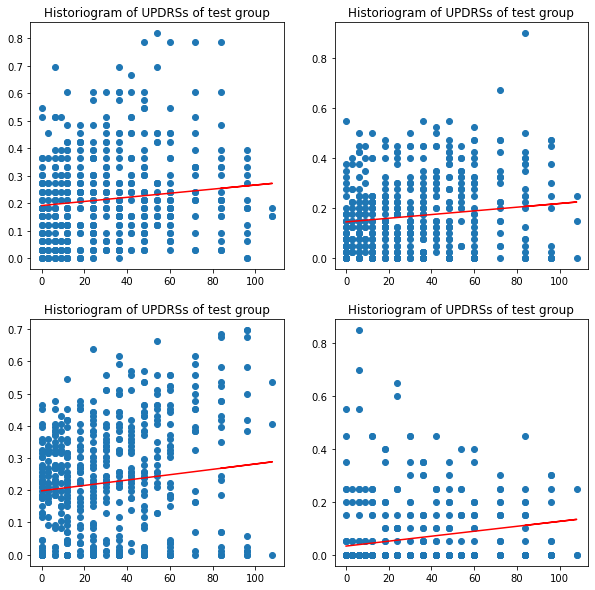

In [28]:
training_length = round(len(patient_id)*0.8)
testing_length  = len(patient_id)-round(len(patient_id)*0.8)
train_lr = patient_id[0:training_length]
test_lr  = patient_id[training_length:len(patient_id)]

linear_regressors_list = []

print('Training set metrics:')
for idx, updrs in enumerate(updrs_cols):
    np_x = train.loc[train_lr]['visit_month'].values.reshape(-1, 1)
    np_y = train.loc[train_lr][updrs].values.reshape(-1, 1)
    lr = linear_regressor_method(np_x, np_y)
    org_dict = { f'{updrs}': lr }
    linear_regressors_list.append(org_dict)
    y_pred = lr.predict(np_x)
    mse_train = mean_squared_error(np_y, y_pred)
    mae_train = mean_absolute_error(np_y, y_pred)
    # mape_train = mean_absolute_percentage_error(np_y, y_pred) * 100
    r2_train = r2_score(np_y, y_pred)
    print(f"\tTraining set of {updrs} mean squared error: {mse_train:.2f}")
    print(f"\tTraining set of {updrs} mean absolute error: {mae_train:.2f}")
    # print(f"\tTraining set of {updrs} mean absolute percentage error: {mape_train:.3f} %")
    print(f"\tTraining set of {updrs} R^2 score: {r2_train:.2f}")

fig, axs = plt.subplots(2, 2,figsize=(10,10))
aux = 0
print('Testing set metrics:')
for idx, updrs in enumerate(updrs_cols):
    np_x = train.loc[test_lr]['visit_month'].values.reshape(-1, 1)
    np_y = train.loc[test_lr][updrs].values.reshape(-1, 1)
    lr   = linear_regressors_list[idx][f'{updrs}']
    # print(linear_regressors_list)
    y_pred = lr.predict(np_x)
    mse_test = mean_squared_error(np_y, y_pred)
    mae_test = mean_absolute_error(np_y, y_pred)
    # mape_test = mean_absolute_percentage_error(np_y, y_pred) * 100
    r2_test = r2_score(np_y, y_pred)
    print(f"\tTesting set of {updrs} mean squared error: {mse_test:.2f}")
    print(f"\tTesting set of {updrs} mean absolute error: {mae_test:.2f}")
    # print(f"\tTesting set of {updrs} mean absolute percentage error: {mape_test:.3f} %")
    print(f"\tTesting set of {updrs} R^2 score: {r2_test:.2f}")
    if(aux == 2):
        aux = 0
    axs[idx//2, aux].scatter(np_x,  np_y)
    axs[idx//2, aux].plot(np_x, lr.predict(np_x), color='red')
    axs[idx//2, aux].set_title(f'Historiogram of UPDRSs of test group')
    aux += 1

# Save the figure
fig.savefig("lr-all-updrs.png")



In [29]:
# Estimate linear regression of evolution od UPDRS over time on each patient

linear_regressors_list = np.zeros(shape=(8,len(patient_id)))

for patient_number, patient in enumerate(patient_id):
    print('Training set metrics:')
    print('Patient number:', patient_number)
    for idx, updrs in enumerate(updrs_cols):
        np_x = train.loc[patient]['visit_month'].values.reshape(-1, 1)
        np_y = train.loc[patient][updrs].values.reshape(-1, 1)
        lr = linear_regressor_method(np_x, np_y)
        org_dict = { f'{updrs}': lr }
        linear_regressors_list[idx,patient_number] = lr.intercept_
        linear_regressors_list[2*idx,patient_number] = lr.coef_
        y_pred = lr.predict(np_x)
        mse_train = mean_squared_error(np_y, y_pred)
        mae_train = mean_absolute_error(np_y, y_pred)
        # mape_train = mean_absolute_percentage_error(np_y, y_pred) * 100
        r2_train = r2_score(np_y, y_pred)
        print(f"\tTraining set of {updrs} mean squared error: {mse_train:.2f}")
        print(f"\tTraining set of {updrs} mean absolute error: {mae_train:.2f}")
        # print(f"\tTraining set of {updrs} mean absolute percentage error: {mape_train:.3f} %")
        print(f"\tTraining set of {updrs} R^2 score: {r2_train:.2f}")

Training set metrics:
Patient number: 0
	Training set of updrs_1 mean squared error: 0.01
	Training set of updrs_1 mean absolute error: 0.07
	Training set of updrs_1 R^2 score: 0.57
	Training set of updrs_2 mean squared error: 0.00
	Training set of updrs_2 mean absolute error: 0.04
	Training set of updrs_2 R^2 score: 0.85
	Training set of updrs_3 mean squared error: 0.00
	Training set of updrs_3 mean absolute error: 0.06
	Training set of updrs_3 R^2 score: 0.73
	Training set of updrs_4 mean squared error: 0.00
	Training set of updrs_4 mean absolute error: 0.00
	Training set of updrs_4 R^2 score: 1.00
Training set metrics:
Patient number: 1
	Training set of updrs_1 mean squared error: 0.00
	Training set of updrs_1 mean absolute error: 0.05
	Training set of updrs_1 R^2 score: 0.06
	Training set of updrs_2 mean squared error: 0.00
	Training set of updrs_2 mean absolute error: 0.02
	Training set of updrs_2 R^2 score: 0.57
	Training set of updrs_3 mean squared error: 0.00
	Training set of u

In [30]:
#Create the training database for XGBoost

training_data_XGB = train[(train["visit_month"] == 0)]
training_data_XGB = training_data_XGB.replace('On',1)
training_data_XGB = training_data_XGB.replace('Off',0)


x_training_XGB = training_data_XGB.loc[:, ~training_data_XGB.columns.isin(['visit_month',	'updrs_1',	'updrs_2',	'updrs_3',	'updrs_4'])]
x_training_XGB = x_training_XGB[0:training_length]
y_training_XGB = linear_regressors_list[4][0:training_length]

x_testing_XGB = training_data_XGB.loc[:, ~training_data_XGB.columns.isin(['visit_month',	'updrs_1',	'updrs_2',	'updrs_3',	'updrs_4'])]
x_testing_XGB = x_testing_XGB[-training_length:]
y_testing_XGB = linear_regressors_list[4][-training_length:]

x_training_XGB.head(20)



,upd23b_clinical_state_on_medication,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,1,0.506663,0.385009,0.589438,0.577661,0.606317,0.428809,0.323142,0.433950,0.412072,...,0.475128,0.592219,0.266399,0.148896,0.144114,0.519776,0.626289,0.454550,0.395872,0.202879
942,0,0.504925,0.194476,0.296838,0.396180,0.071718,0.247097,0.289777,0.285920,0.184275,...,0.538369,0.224044,0.015471,0.079620,0.119042,0.315697,0.298863,0.599682,0.412893,0.214097
1517,1,0.525923,0.205634,0.519663,0.223315,0.312581,0.271501,0.208973,0.261991,0.185358,...,0.498007,0.238256,0.277087,0.140714,0.191079,0.258495,0.429223,0.487557,0.380823,0.286704
1923,0,1.000000,0.462018,0.473187,0.797091,0.225277,0.292549,0.499804,0.575951,0.388137,...,0.763587,0.622074,0.193434,0.081710,0.104645,0.435122,0.598925,0.484351,0.610626,0.078405
2660,0,0.714682,0.297672,0.415062,0.371222,0.348153,0.171703,0.239258,0.492983,0.249106,...,0.699041,0.232309,0.437992,0.020612,0.028934,0.326011,0.453343,0.433641,0.331067,0.327138
3636,1,0.488735,0.118862,0.155339,0.119692,0.081798,0.291293,0.098336,0.152939,0.058214,...,0.496097,0.000000,0.300775,0.132498,0.413796,0.240055,0.399413,0.298753,0.169698,0.351583
3863,1,0.562954,0.358669,0.402434,0.523169,0.427900,0.002625,0.307837,0.487622,0.269355,...,0.142158,0.494503,0.058131,0.195825,0.370944,0.383159,0.487818,0.503854,0.444482,0.282796
4161,0,0.559469,0.580927,0.365294,0.779948,0.129385,0.204484,0.462008,0.298862,0.183795,...,0.471952,0.245764,0.579690,0.069932,0.124683,0.507257,0.266723,0.380110,0.180975,0.110287
4172,0,0.422016,0.222161,0.338409,0.254559,0.429852,0.189084,0.126402,0.279981,0.229866,...,0.387545,0.359217,0.120132,0.072683,0.110422,0.269330,0.540585,0.507366,0.498842,0.344011


In [39]:
# Try to predict the regression values from proteins using XGBOOST
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
XGBModel = ensemble.GradientBoostingRegressor(**params)
XGBModel.fit(x_training_XGB, y_training_XGB)

mse = mean_squared_error(y_testing_XGB, XGBModel.predict(x_testing_XGB))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))



The mean squared error (MSE) on test set: 0.0000


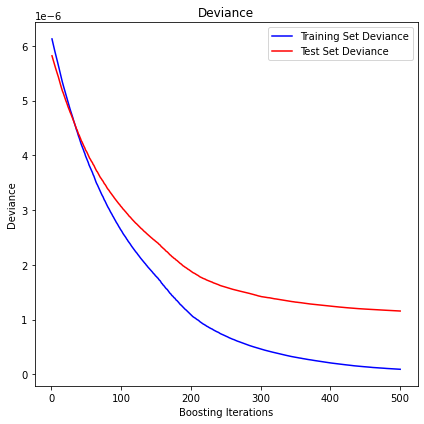

In [40]:
# Visualize the results
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(XGBModel.staged_predict(x_testing_XGB)):
    test_score[i] = mean_squared_error(y_testing_XGB, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    XGBModel.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()


In [41]:
print(train.columns[6:])

Index(['O00391', 'O00533', 'O00584', 'O14498', 'O14773', 'O14791', 'O15240',
       'O15394', 'O43505', 'O60888',
       ...
       'YSLTYIYTGLSK', 'YTTEIIK', 'YVGGQEHFAHLLILR',
       'YVM(UniMod_35)LPVADQDQC(UniMod_4)IR', 'YVMLPVADQDQC(UniMod_4)IR',
       'YVNKEIQNAVNGVK', 'YWGVASFLQK', 'YYC(UniMod_4)FQGNQFLR', 'YYTYLIMNK',
       'YYWGGQYTWDMAK'],
      dtype='object', length=1195)


Mean Absolute Error of updrs 1: 0.084716060129444


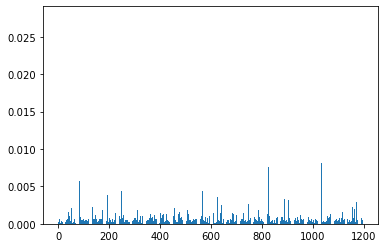

In [42]:
# Now we will use a regression model to predict the updrs based on protein levels
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train[train.columns[6:]], train.updrs_1, test_size=0.2, random_state=42)

# Create a Random Forest Regressor object with default parameters
rf1 = RandomForestRegressor()

# Fit the model to the training data
rf1.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf1.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of updrs 1:', mae)

# plot feature importance graph
plt.bar(range(len(rf1.feature_importances_)), rf1.feature_importances_)
plt.show()

Mean Absolute Error of updrs 2: 0.06857604551943701


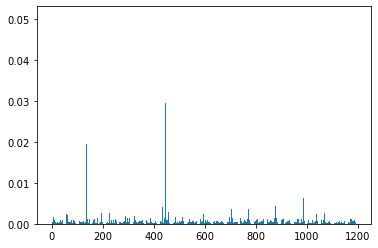

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train[train.columns[6:]], train.updrs_2, test_size=0.2, random_state=42)

# Create a Random Forest Regressor object with default parameters
rf2 = RandomForestRegressor()

# Fit the model to the training data
rf2.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf2.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of updrs 2:', mae)

# plot feature importance graph
plt.bar(range(len(rf2.feature_importances_)), rf2.feature_importances_)
plt.show()

Mean Absolute Error of updrs 3: 0.0805895728145995


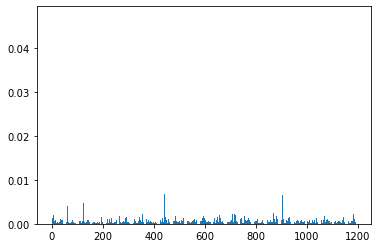

In [44]:
X_train, X_test, y_train, y_test = train_test_split(train[train.columns[6:]], train.updrs_3, test_size=0.2, random_state=42)

# Create a Random Forest Regressor object with default parameters
rf3 = RandomForestRegressor()

# Fit the model to the training data
rf3.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf3.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of updrs 3:', mae)

# plot feature importance graph
plt.bar(range(len(rf3.feature_importances_)), rf3.feature_importances_)
plt.show()

Mean Absolute Error of updrs 4: 0.05806653152425


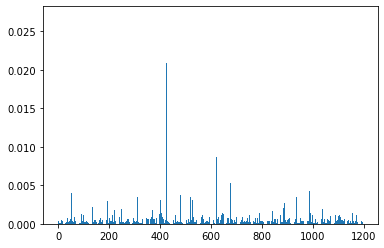

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train[train.columns[6:]], train.updrs_4, test_size=0.2, random_state=42)

# Create a Random Forest Regressor object with default parameters
rf4 = RandomForestRegressor()

# Fit the model to the training data
rf4.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf4.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of updrs 4:', mae)

# plot feature importance graph
plt.bar(range(len(rf4.feature_importances_)), rf4.feature_importances_)
plt.show()

In [46]:
print(train.updrs_1)

patient_id
55       0.303030
55       0.303030
55       0.242424
55       0.242424
55       0.303030
           ...   
65043    0.212121
65043    0.121212
65043    0.181818
65043    0.090909
65043    0.212121
Name: updrs_1, Length: 2615, dtype: float64


In [47]:
print(y_pred)

[1.67333333e-01 2.76250000e-02 1.20000000e-02 4.50000000e-03
 9.50000000e-03 3.06916667e-01 9.00000000e-03 1.66441667e-01
 9.12464286e-02 5.00000000e-03 0.00000000e+00 1.92679654e-02
 9.77750000e-02 7.85950397e-02 5.19285714e-02 8.93333333e-02
 3.19166667e-02 8.71500000e-02 5.16666667e-03 1.24285714e-02
 2.17000000e-01 2.07500000e-02 3.97277778e-02 0.00000000e+00
 1.75000000e-02 1.05000000e-02 2.42500000e-02 5.42857143e-02
 1.86136905e-01 6.00000000e-03 5.41250000e-02 1.85000000e-02
 3.68125000e-02 1.26666667e-02 1.53333333e-02 0.00000000e+00
 2.82344048e-01 3.39196429e-02 2.35000000e-02 1.20000000e-03
 6.66666667e-03 7.33954545e-02 1.38091667e-01 5.10625000e-02
 1.83526209e-01 2.00000000e-02 4.60000000e-03 1.11288492e-01
 6.43333333e-03 5.00000000e-04 2.80166667e-02 9.25250000e-02
 0.00000000e+00 2.48033333e-01 0.00000000e+00 3.98809524e-02
 1.29857143e-01 2.15833333e-02 2.94750000e-02 2.11000000e-02
 3.00000000e-03 6.91666667e-03 3.60000000e-02 2.77777778e-03
 6.39041667e-02 1.940000

In [48]:
print(y_test)

patient_id
64674    0.20
24820    0.05
56317    0.00
26210    0.00
49683    0.00
         ... 
13618    0.25
60326    0.00
12931    0.00
30416    0.05
64674    0.30
Name: updrs_4, Length: 523, dtype: float64


In [53]:
# Load all datasets
test_proteins = pd.read_csv("./example_test_files/test_proteins.csv")
test_peptides = pd.read_csv("./example_test_files/test_peptides.csv")

# Pivot the proteins and peptides tables so each protein and peptide is a feature
test_proteins = test_proteins.pivot_table(values="NPX", index="visit_id", columns="UniProt")
test_peptides = test_peptides.pivot_table(values="PeptideAbundance", index="visit_id", columns="Peptide")

# Merge the three tables
test = test_proteins.merge(test_peptides, on="visit_id", how="left")

test.head()
# Set the patient id as index
# test = test.set_index(["patient_id"])

# test = test.drop("visit_id", axis=1)
# # Create a list of the ids of the patients
# patient_id_test = list(test.index.unique())

# # Interpolate the missing data of every patient
# for patient in patient_id_test:
#     test.loc[patient] = test.loc[patient].interpolate(method="linear").fillna(method="bfill")

# # Fill updrs and state of medication values
# test.updrs_4 = test.updrs_4.fillna(0)
# test.upd23b_clinical
# # Adjust updr4 values to possible values
# test.updrs_4 = round(test.updrs_4)

# # Check missing values after interpolate
# print("Total missing values left: {}".format(test.isna().sum().sum()))
# print(test.isna().sum().sort_values(ascending=False))
# # Fill the remaining na values with the mean of the columns
# test = test.fillna(test.mean())

# # s = test.columns.values
# # e = ['upd23b_clinical_state_on_medication', 'visit_month']
# # norm_columns = set(train.columns.values)-set(e)
# # print(len(set(train.columns.values)))
# # print(len(set(train.columns.values)-set(e)))

,O00391,O00533,O00584,O14498,O14773,O14791,O15031,O15240,O15394,O43505,...,YSSDYFQAPSDYR,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
3342_6,14564.0,616804.0,61418.1,27830.1,14959.2,2853.12,NaN,223373.0,58863.0,207497.0,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
50423_0,33127.9,490742.0,43615.3,NaN,16486.6,2882.42,11963.7,124344.0,57688.1,200364.0,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
